In [1]:
from helpers import *
import pandas as pd
from xgboost import XGBRegressor
import seaborn as sns
import matplotlib.pyplot as plt
import random
import warnings 
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# ignore warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# auto reloading library (mainly for altering helpers.py)
%load_ext autoreload
%autoreload 2

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
training_filters = [
    {
        'feature': 'month',
        'operator': 'between',
        'value': [3, 9]
    }
]

validation_filters = [
    {
        'feature': 'date_forecast',
        'operator': 'between',
        'value': ['2020-05-01', '2020-07-01']
    }
]

test_filters = [
    {
        'feature': 'date_forecast',
        'operator': 'between',
        'value': ['2021-05-01', '2021-07-01']
    }
]

In [4]:
agg_strats = ['mean']

m_wrap = DataWrapper(
    impute_strategy = 'fbfill',
    aggregation_strats = agg_strats,
    y_scalers = [Y_Scaler_MaxAbs_per_building()],
    transform_pred_strategy = [],
    training_filters=training_filters,
    validation_filters=validation_filters,
    test_filters=test_filters,
    bagging_filters=False, # these are applied additionally to the other filters on val, test, sub
    )

predictions = m_wrap.get_sub(aggregated=True)

{'a': 5733.42, 'b': 1152.3, 'c': 999.6}
{'a': 5733.42, 'b': 1152.3, 'c': 999.6}


In [5]:
predictions.columns

Index(['building_id', 'hourDayMonthYear', 'isEstimated', 'delta_forecast',
       'date_forecast', 'dayMonthYear', 'monthYear', 'month', 'hour',
       'mean_date_calc', 'mean_absolute_humidity_2m:gm3',
       'mean_air_density_2m:kgm3', 'mean_ceiling_height_agl:m',
       'mean_clear_sky_energy_1h:J', 'mean_clear_sky_rad:W',
       'mean_cloud_base_agl:m', 'mean_dew_or_rime:idx', 'mean_dew_point_2m:K',
       'mean_diffuse_rad:W', 'mean_diffuse_rad_1h:J', 'mean_direct_rad:W',
       'mean_direct_rad_1h:J', 'mean_effective_cloud_cover:p',
       'mean_is_day:idx', 'mean_is_in_shadow:idx', 'mean_msl_pressure:hPa',
       'mean_precip_5min:mm', 'mean_precip_type_5min:idx',
       'mean_pressure_100m:hPa', 'mean_pressure_50m:hPa', 'mean_prob_rime:p',
       'mean_rain_water:kgm2', 'mean_relative_humidity_1000hPa:p',
       'mean_sfc_pressure:hPa', 'mean_sun_azimuth:d', 'mean_sun_elevation:d',
       'mean_super_cooled_liquid_water:kgm2', 'mean_t_1000hPa:K',
       'mean_total_cloud_cover:

# Model 1

In [6]:
agg_strats = ['min','max']
rand_incr = 1
name = 'MinMax'

m_wrap = DataWrapper(
    impute_strategy = 'fbfill',
    aggregation_strats = agg_strats,
    y_scalers = [Y_Scaler_MaxAbs_per_building()],
    transform_pred_strategy = [],
    training_filters=training_filters,
    validation_filters=validation_filters,
    test_filters=test_filters,
    bagging_filters=False, # these are applied additionally to the other filters on val, test, sub
    )

X_train_agg, y_train_agg = m_wrap.get_train(aggregated=True,drop_val=False,drop_test=False,y_scaled=True)
X_train_agg = X_train_agg.select_dtypes(exclude=['datetime','timedelta','period[M]'])

X_sub_agg = m_wrap.get_sub(aggregated=True)

# automatically set types of columns for imputing and oneHotEncoding
categorical_features = X_train_agg.select_dtypes(include=['object']).columns.tolist()
impute_features = X_train_agg.loc[:, X_train_agg.isna().any()].columns.tolist()


for i in range(8):
    # automatically set types of columns for imputing and oneHotEncoding
    columnTransformer = ColumnTransformer(
        transformers=[
            ('imputer', SimpleImputer(strategy='constant'),impute_features),
            ('oneHotEncoder', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ],
        remainder='passthrough',  # Dont drop remaining columns
        n_jobs=-1
    )

    mod = CatBoostRegressor(
        objective='MAE',
        iterations=800,
        depth=12,
        random_seed=i*100+rand_incr,
    )

    model = Pipeline(steps=[
        ('columnTransformer', columnTransformer),
        ('estimator', mod)
    ])


    model.fit(X_train_agg, y_train_agg)
    pred_sub = pd.Series(model.predict(X_sub_agg))
    pred_sub = pd.Series(m_wrap.transform_prediction(pred_sub, X_sub_agg))

    predictions[f'{name}_{i}'] = pred_sub

{'a': 5733.42, 'b': 1152.3, 'c': 999.6}
{'a': 5733.42, 'b': 1152.3, 'c': 999.6}
0:	learn: 0.1541215	total: 204ms	remaining: 2m 42s
1:	learn: 0.1501101	total: 379ms	remaining: 2m 31s
2:	learn: 0.1459939	total: 493ms	remaining: 2m 11s
3:	learn: 0.1420248	total: 607ms	remaining: 2m
4:	learn: 0.1383327	total: 720ms	remaining: 1m 54s
5:	learn: 0.1348207	total: 851ms	remaining: 1m 52s
6:	learn: 0.1317561	total: 865ms	remaining: 1m 37s
7:	learn: 0.1283824	total: 977ms	remaining: 1m 36s
8:	learn: 0.1252243	total: 1.11s	remaining: 1m 37s
9:	learn: 0.1220848	total: 1.24s	remaining: 1m 37s
10:	learn: 0.1190510	total: 1.35s	remaining: 1m 36s
11:	learn: 0.1161416	total: 1.46s	remaining: 1m 35s
12:	learn: 0.1133316	total: 1.58s	remaining: 1m 35s
13:	learn: 0.1107856	total: 1.71s	remaining: 1m 35s
14:	learn: 0.1081094	total: 1.85s	remaining: 1m 36s
15:	learn: 0.1055359	total: 1.99s	remaining: 1m 37s
16:	learn: 0.1031010	total: 2.1s	remaining: 1m 36s
17:	learn: 0.1007692	total: 2.22s	remaining: 1m 36s

In [7]:
agg_strats = ['mean','std']
rand_incr = 2
name = 'MeanStd'

m_wrap = DataWrapper(
    impute_strategy = 'fbfill',
    aggregation_strats = agg_strats,
    y_scalers = [Y_Scaler_MaxAbs_per_building()],
    transform_pred_strategy = [],
    training_filters=training_filters,
    validation_filters=validation_filters,
    test_filters=test_filters,
    bagging_filters=False, # these are applied additionally to the other filters on val, test, sub
    )

X_train_agg, y_train_agg = m_wrap.get_train(aggregated=True,drop_val=False,drop_test=False,y_scaled=True)
X_train_agg = X_train_agg.select_dtypes(exclude=['datetime','timedelta','period[M]'])

X_sub_agg = m_wrap.get_sub(aggregated=True)

# automatically set types of columns for imputing and oneHotEncoding
categorical_features = X_train_agg.select_dtypes(include=['object']).columns.tolist()
impute_features = X_train_agg.loc[:, X_train_agg.isna().any()].columns.tolist()


for i in range(8):
    # automatically set types of columns for imputing and oneHotEncoding
    columnTransformer = ColumnTransformer(
        transformers=[
            ('imputer', SimpleImputer(strategy='constant'),impute_features),
            ('oneHotEncoder', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ],
        remainder='passthrough',  # Dont drop remaining columns
        n_jobs=-1
    )

    mod = CatBoostRegressor(
        objective='MAE',
        iterations=800,
        depth=12,
        random_seed=i*100+rand_incr,
    )

    model = Pipeline(steps=[
        ('columnTransformer', columnTransformer),
        ('estimator', mod)
    ])


    model.fit(X_train_agg, y_train_agg)
    pred_sub = pd.Series(model.predict(X_sub_agg))
    pred_sub = pd.Series(m_wrap.transform_prediction(pred_sub, X_sub_agg))

    predictions[f'{name}_{i}'] = pred_sub

{'a': 5733.42, 'b': 1152.3, 'c': 999.6}
{'a': 5733.42, 'b': 1152.3, 'c': 999.6}
0:	learn: 0.1540808	total: 123ms	remaining: 1m 38s
1:	learn: 0.1504799	total: 236ms	remaining: 1m 34s
2:	learn: 0.1464981	total: 341ms	remaining: 1m 30s
3:	learn: 0.1424778	total: 455ms	remaining: 1m 30s
4:	learn: 0.1387129	total: 580ms	remaining: 1m 32s
5:	learn: 0.1351128	total: 688ms	remaining: 1m 31s
6:	learn: 0.1315935	total: 805ms	remaining: 1m 31s
7:	learn: 0.1282341	total: 924ms	remaining: 1m 31s
8:	learn: 0.1249520	total: 1.04s	remaining: 1m 31s
9:	learn: 0.1217828	total: 1.15s	remaining: 1m 30s
10:	learn: 0.1187080	total: 1.27s	remaining: 1m 31s
11:	learn: 0.1157775	total: 1.38s	remaining: 1m 30s
12:	learn: 0.1129852	total: 1.5s	remaining: 1m 30s
13:	learn: 0.1102720	total: 1.6s	remaining: 1m 30s
14:	learn: 0.1077230	total: 1.71s	remaining: 1m 29s
15:	learn: 0.1051585	total: 1.81s	remaining: 1m 28s
16:	learn: 0.1026773	total: 1.92s	remaining: 1m 28s
17:	learn: 0.1004075	total: 2.02s	remaining: 1m 

In [8]:
agg_strats = ['mean','std','min','max','00','15','30','45']
rand_incr = 3
name = 'Everything'

m_wrap = DataWrapper(
    impute_strategy = 'fbfill',
    aggregation_strats = agg_strats,
    y_scalers = [Y_Scaler_MaxAbs_per_building()],
    transform_pred_strategy = [],
    training_filters=training_filters,
    validation_filters=validation_filters,
    test_filters=test_filters,
    bagging_filters=False, # these are applied additionally to the other filters on val, test, sub
    )

X_train_agg, y_train_agg = m_wrap.get_train(aggregated=True,drop_val=False,drop_test=False,y_scaled=True)
X_train_agg = X_train_agg.select_dtypes(exclude=['datetime','timedelta','period[M]'])

X_sub_agg = m_wrap.get_sub(aggregated=True)

# automatically set types of columns for imputing and oneHotEncoding
categorical_features = X_train_agg.select_dtypes(include=['object']).columns.tolist()
impute_features = X_train_agg.loc[:, X_train_agg.isna().any()].columns.tolist()


for i in range(8):
    # automatically set types of columns for imputing and oneHotEncoding
    columnTransformer = ColumnTransformer(
        transformers=[
            ('imputer', SimpleImputer(strategy='constant'),impute_features),
            ('oneHotEncoder', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ],
        remainder='passthrough',  # Dont drop remaining columns
        n_jobs=-1
    )

    mod = CatBoostRegressor(
        objective='MAE',
        iterations=800,
        depth=12,
        random_seed=i*100+rand_incr,
    )

    model = Pipeline(steps=[
        ('columnTransformer', columnTransformer),
        ('estimator', mod)
    ])


    model.fit(X_train_agg, y_train_agg)
    pred_sub = pd.Series(model.predict(X_sub_agg))
    pred_sub = pd.Series(m_wrap.transform_prediction(pred_sub, X_sub_agg))

    predictions[f'{name}_{i}'] = pred_sub

{'a': 5733.42, 'b': 1152.3, 'c': 999.6}
{'a': 5733.42, 'b': 1152.3, 'c': 999.6}
0:	learn: 0.1541650	total: 422ms	remaining: 5m 36s
1:	learn: 0.1499896	total: 870ms	remaining: 5m 47s
2:	learn: 0.1461008	total: 1.35s	remaining: 5m 59s
3:	learn: 0.1421049	total: 1.76s	remaining: 5m 50s
4:	learn: 0.1385154	total: 2.24s	remaining: 5m 55s
5:	learn: 0.1349069	total: 2.82s	remaining: 6m 13s
6:	learn: 0.1312342	total: 3.33s	remaining: 6m 17s
7:	learn: 0.1278761	total: 3.79s	remaining: 6m 15s
8:	learn: 0.1246557	total: 4.22s	remaining: 6m 11s
9:	learn: 0.1213939	total: 4.68s	remaining: 6m 9s
10:	learn: 0.1183780	total: 5.17s	remaining: 6m 10s
11:	learn: 0.1153864	total: 5.63s	remaining: 6m 9s
12:	learn: 0.1124873	total: 6.06s	remaining: 6m 6s
13:	learn: 0.1097810	total: 6.53s	remaining: 6m 6s
14:	learn: 0.1072321	total: 6.99s	remaining: 6m 5s
15:	learn: 0.1047421	total: 7.47s	remaining: 6m 6s
16:	learn: 0.1023324	total: 8s	remaining: 6m 8s
17:	learn: 0.1001020	total: 8.44s	remaining: 6m 6s
18:	l

In [9]:
predictions

,building_id,hourDayMonthYear,isEstimated,delta_forecast,date_forecast,dayMonthYear,monthYear,month,hour,mean_date_calc,mean_absolute_humidity_2m:gm3,mean_air_density_2m:kgm3,mean_ceiling_height_agl:m,mean_clear_sky_energy_1h:J,mean_clear_sky_rad:W,mean_cloud_base_agl:m,mean_dew_or_rime:idx,mean_dew_point_2m:K,mean_diffuse_rad:W,mean_diffuse_rad_1h:J,mean_direct_rad:W,mean_direct_rad_1h:J,mean_effective_cloud_cover:p,mean_is_day:idx,mean_is_in_shadow:idx,mean_msl_pressure:hPa,mean_precip_5min:mm,mean_precip_type_5min:idx,mean_pressure_100m:hPa,mean_pressure_50m:hPa,mean_prob_rime:p,mean_rain_water:kgm2,mean_relative_humidity_1000hPa:p,mean_sfc_pressure:hPa,mean_sun_azimuth:d,mean_sun_elevation:d,mean_super_cooled_liquid_water:kgm2,mean_t_1000hPa:K,mean_total_cloud_cover:p,mean_visibility:m,mean_wind_speed_10m:ms,mean_wind_speed_u_10m:ms,mean_wind_speed_v_10m:ms,mean_wind_speed_w_1000hPa:ms,mean_GHI,mean_wind_angle,mean_temp*GHI,mean_wind*humidity,mean_sun_height*diff_rad,mean_wind_angle_sin,mean_wind_angle_cos,mean_hour_sin,mean_hour_cos,mean_GHI_daily_mean,mean_GHI_daily_std,mean_effective_cloud_cover_5h_mean,mean_GHI_lag_-1h,mean_GHI_lag_1h,mean_temp*GHI_lag_-1h,mean_temp*GHI_lag_1h,MinMax_0,MinMax_1,MinMax_2,MinMax_3,MinMax_4,MinMax_5,MinMax_6,MinMax_7,MeanStd_0,MeanStd_1,MeanStd_2,MeanStd_3,MeanStd_4,MeanStd_5,MeanStd_6,MeanStd_7,Everything_0,Everything_1,Everything_2,Everything_3,Everything_4,Everything_5,Everything_6,Everything_7
0,a,2023-05-01 00:00:00,1,16.998889,2023-05-01 00:00:00,2023-05-01,2023-05,5,0,2023-04-30 07:00:04,4.325,1.28675,912.700012,0.000000,0.000000,1061.550049,0.0,271.650024,0.000000,0.000000,0.000000,0.000000,74.949997,0.00,1.0,1013.674988,0.0,0.0,1000.549988,1006.799988,0.0,0.0,80.275002,1013.099976,16.026501,-10.541000,0.000,273.799988,74.949997,29907.500000,3.950,2.100,3.350,0.0,0.000000,0.559798,0.000000,317.087524,0.000000,0.530980,0.847307,0.000000,1.000000,202.039597,198.742325,79.793338,0.000000,NaN,0.000000,NaN,4.167876,-9.397586,-9.818050,0.142508,0.036054,-3.979292,-1.679616,1.833603,2.150700,3.194887,-9.769632,-23.793892,-1.949843,0.010733,0.415021,-0.144279,1.733808,-0.432517,-0.002608,0.157291,0.097662,4.735704,0.078844,-0.025302
1,a,2023-05-01 01:00:00,1,17.998889,2023-05-01 01:00:00,2023-05-01,2023-05,5,1,2023-04-30 07:00:04,4.275,1.28600,1482.099976,0.000000,0.000000,1075.100098,0.0,271.450012,0.000000,0.000000,0.000000,0.000000,77.474998,0.00,1.0,1013.150024,0.0,0.0,1000.049988,1006.299988,0.0,0.0,79.824997,1012.599976,30.497250,-7.894500,0.000,273.799988,77.474998,29519.074219,3.825,1.925,3.300,0.0,0.000000,0.528019,0.000000,305.339996,0.000000,0.503799,0.863766,0.258819,0.965926,202.039597,198.742325,76.806456,0.000000,0.000000,0.000000,0.000000,-4.562086,-11.359927,-9.780099,-9.338549,-0.751143,0.172738,-0.805903,1.439864,2.150357,-0.033224,-0.917551,-0.120867,0.251017,0.978144,2.745224,-0.058066,0.913647,0.959684,-0.033205,-0.005839,0.078888,-0.271067,0.270207,-0.008937
2,a,2023-05-01 02:00:00,1,18.998889,2023-05-01 02:00:00,2023-05-01,2023-05,5,2,2023-04-30 07:00:04,4.150,1.28375,1791.300049,0.000000,0.000000,1200.400024,0.0,271.049988,0.000000,0.000000,0.000000,0.000000,88.099998,0.00,1.0,1012.674988,0.0,0.0,999.500000,1005.799988,0.0,0.0,78.000000,1012.049988,44.517250,-3.815500,0.000,273.849976,88.099998,31009.125000,3.650,1.750,3.200,0.0,0.000000,0.500362,0.000000,284.739990,0.000000,0.479708,0.877346,0.500000,0.866025,202.039597,198.742325,75.134157,11.475000,0.000000,3143.002441,0.000000,-2.225266,-10.607480,0.153839,-1.904889,1.357481,-1.924947,-0.551344,0.024655,-0.406549,4.243471,-7.448800,-2.225860,-0.594311,-13.834814,-6.084041,-1.314721,2.017594,1.633412,9.047772,-10.830324,9.243624,2.403556,-18.635086,-0.579348
3,a,2023-05-01 03:00:00,1,19.998889,2023-05-01 03:00:00,2023-05-01,2023-05,5,3,2023-04-30 07:00:04,4.025,1.28200,2312.875000,10124.424805,11.675000,1179.849976,0.0,270.649994,9.375000,16845.226562,2.100000,3765.350098,68.599998,0.75,0.5,1012.174988,0.0,0.0,

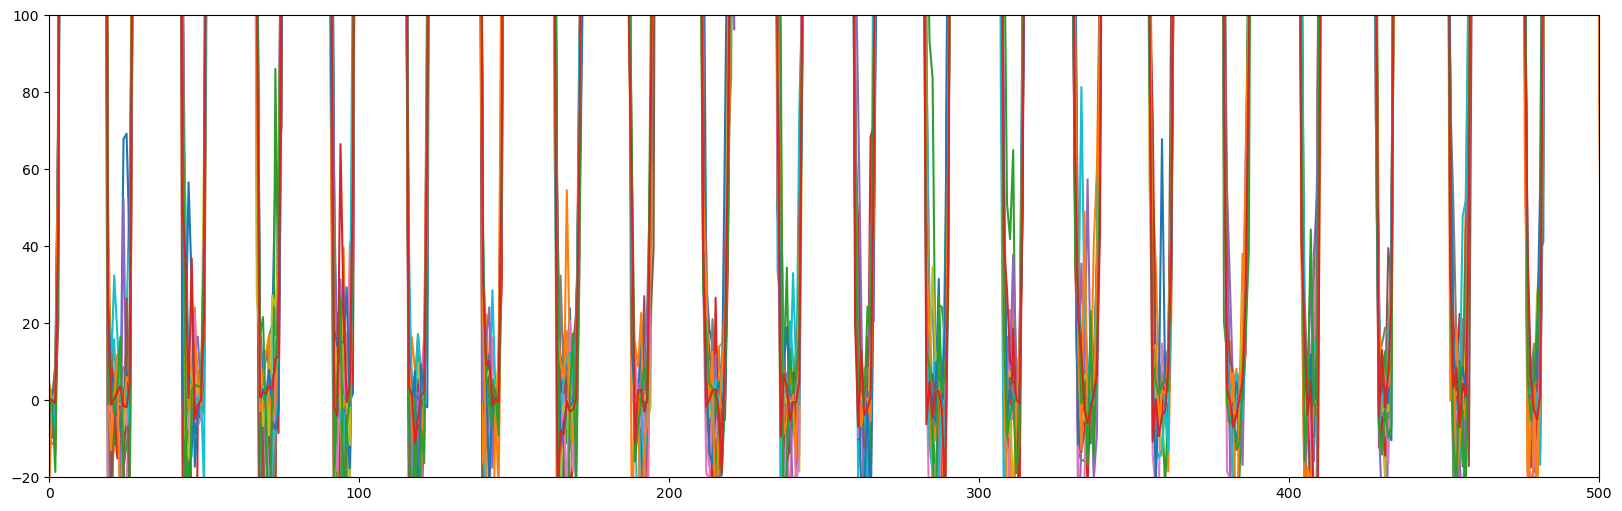

In [10]:
pred_only_pred = predictions.iloc[:,-24:]
plt.figure(figsize=(20,6))
plt.xlim(0,500)
plt.ylim(-20,100)
plt.plot(pred_only_pred);

In [11]:
predictions

,building_id,hourDayMonthYear,isEstimated,delta_forecast,date_forecast,dayMonthYear,monthYear,month,hour,mean_date_calc,mean_absolute_humidity_2m:gm3,mean_air_density_2m:kgm3,mean_ceiling_height_agl:m,mean_clear_sky_energy_1h:J,mean_clear_sky_rad:W,mean_cloud_base_agl:m,mean_dew_or_rime:idx,mean_dew_point_2m:K,mean_diffuse_rad:W,mean_diffuse_rad_1h:J,mean_direct_rad:W,mean_direct_rad_1h:J,mean_effective_cloud_cover:p,mean_is_day:idx,mean_is_in_shadow:idx,mean_msl_pressure:hPa,mean_precip_5min:mm,mean_precip_type_5min:idx,mean_pressure_100m:hPa,mean_pressure_50m:hPa,mean_prob_rime:p,mean_rain_water:kgm2,mean_relative_humidity_1000hPa:p,mean_sfc_pressure:hPa,mean_sun_azimuth:d,mean_sun_elevation:d,mean_super_cooled_liquid_water:kgm2,mean_t_1000hPa:K,mean_total_cloud_cover:p,mean_visibility:m,mean_wind_speed_10m:ms,mean_wind_speed_u_10m:ms,mean_wind_speed_v_10m:ms,mean_wind_speed_w_1000hPa:ms,mean_GHI,mean_wind_angle,mean_temp*GHI,mean_wind*humidity,mean_sun_height*diff_rad,mean_wind_angle_sin,mean_wind_angle_cos,mean_hour_sin,mean_hour_cos,mean_GHI_daily_mean,mean_GHI_daily_std,mean_effective_cloud_cover_5h_mean,mean_GHI_lag_-1h,mean_GHI_lag_1h,mean_temp*GHI_lag_-1h,mean_temp*GHI_lag_1h,MinMax_0,MinMax_1,MinMax_2,MinMax_3,MinMax_4,MinMax_5,MinMax_6,MinMax_7,MeanStd_0,MeanStd_1,MeanStd_2,MeanStd_3,MeanStd_4,MeanStd_5,MeanStd_6,MeanStd_7,Everything_0,Everything_1,Everything_2,Everything_3,Everything_4,Everything_5,Everything_6,Everything_7
0,a,2023-05-01 00:00:00,1,16.998889,2023-05-01 00:00:00,2023-05-01,2023-05,5,0,2023-04-30 07:00:04,4.325,1.28675,912.700012,0.000000,0.000000,1061.550049,0.0,271.650024,0.000000,0.000000,0.000000,0.000000,74.949997,0.00,1.0,1013.674988,0.0,0.0,1000.549988,1006.799988,0.0,0.0,80.275002,1013.099976,16.026501,-10.541000,0.000,273.799988,74.949997,29907.500000,3.950,2.100,3.350,0.0,0.000000,0.559798,0.000000,317.087524,0.000000,0.530980,0.847307,0.000000,1.000000,202.039597,198.742325,79.793338,0.000000,NaN,0.000000,NaN,4.167876,-9.397586,-9.818050,0.142508,0.036054,-3.979292,-1.679616,1.833603,2.150700,3.194887,-9.769632,-23.793892,-1.949843,0.010733,0.415021,-0.144279,1.733808,-0.432517,-0.002608,0.157291,0.097662,4.735704,0.078844,-0.025302
1,a,2023-05-01 01:00:00,1,17.998889,2023-05-01 01:00:00,2023-05-01,2023-05,5,1,2023-04-30 07:00:04,4.275,1.28600,1482.099976,0.000000,0.000000,1075.100098,0.0,271.450012,0.000000,0.000000,0.000000,0.000000,77.474998,0.00,1.0,1013.150024,0.0,0.0,1000.049988,1006.299988,0.0,0.0,79.824997,1012.599976,30.497250,-7.894500,0.000,273.799988,77.474998,29519.074219,3.825,1.925,3.300,0.0,0.000000,0.528019,0.000000,305.339996,0.000000,0.503799,0.863766,0.258819,0.965926,202.039597,198.742325,76.806456,0.000000,0.000000,0.000000,0.000000,-4.562086,-11.359927,-9.780099,-9.338549,-0.751143,0.172738,-0.805903,1.439864,2.150357,-0.033224,-0.917551,-0.120867,0.251017,0.978144,2.745224,-0.058066,0.913647,0.959684,-0.033205,-0.005839,0.078888,-0.271067,0.270207,-0.008937
2,a,2023-05-01 02:00:00,1,18.998889,2023-05-01 02:00:00,2023-05-01,2023-05,5,2,2023-04-30 07:00:04,4.150,1.28375,1791.300049,0.000000,0.000000,1200.400024,0.0,271.049988,0.000000,0.000000,0.000000,0.000000,88.099998,0.00,1.0,1012.674988,0.0,0.0,999.500000,1005.799988,0.0,0.0,78.000000,1012.049988,44.517250,-3.815500,0.000,273.849976,88.099998,31009.125000,3.650,1.750,3.200,0.0,0.000000,0.500362,0.000000,284.739990,0.000000,0.479708,0.877346,0.500000,0.866025,202.039597,198.742325,75.134157,11.475000,0.000000,3143.002441,0.000000,-2.225266,-10.607480,0.153839,-1.904889,1.357481,-1.924947,-0.551344,0.024655,-0.406549,4.243471,-7.448800,-2.225860,-0.594311,-13.834814,-6.084041,-1.314721,2.017594,1.633412,9.047772,-10.830324,9.243624,2.403556,-18.635086,-0.579348
3,a,2023-05-01 03:00:00,1,19.998889,2023-05-01 03:00:00,2023-05-01,2023-05,5,3,2023-04-30 07:00:04,4.025,1.28200,2312.875000,10124.424805,11.675000,1179.849976,0.0,270.649994,9.375000,16845.226562,2.100000,3765.350098,68.599998,0.75,0.5,1012.174988,0.0,0.0,

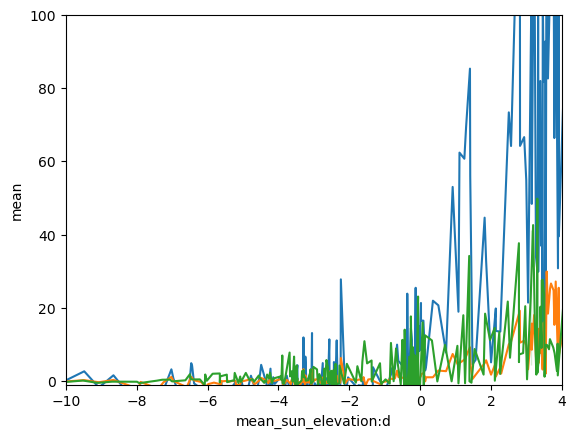

In [12]:
predictions['mean'] = pred_only_pred.mean(axis=1)
plt.xlim(-10,4)
plt.ylim(-1,100)
sns.lineplot(data=predictions, x='mean_sun_elevation:d', y='mean', hue='building_id', legend=False);

In [13]:
predictions.columns

Index(['building_id', 'hourDayMonthYear', 'isEstimated', 'delta_forecast',
       'date_forecast', 'dayMonthYear', 'monthYear', 'month', 'hour',
       'mean_date_calc', 'mean_absolute_humidity_2m:gm3',
       'mean_air_density_2m:kgm3', 'mean_ceiling_height_agl:m',
       'mean_clear_sky_energy_1h:J', 'mean_clear_sky_rad:W',
       'mean_cloud_base_agl:m', 'mean_dew_or_rime:idx', 'mean_dew_point_2m:K',
       'mean_diffuse_rad:W', 'mean_diffuse_rad_1h:J', 'mean_direct_rad:W',
       'mean_direct_rad_1h:J', 'mean_effective_cloud_cover:p',
       'mean_is_day:idx', 'mean_is_in_shadow:idx', 'mean_msl_pressure:hPa',
       'mean_precip_5min:mm', 'mean_precip_type_5min:idx',
       'mean_pressure_100m:hPa', 'mean_pressure_50m:hPa', 'mean_prob_rime:p',
       'mean_rain_water:kgm2', 'mean_relative_humidity_1000hPa:p',
       'mean_sfc_pressure:hPa', 'mean_sun_azimuth:d', 'mean_sun_elevation:d',
       'mean_super_cooled_liquid_water:kgm2', 'mean_t_1000hPa:K',
       'mean_total_cloud_cover:

In [14]:
predictions['mean'] = predictions['mean'].clip(0)
predictions.loc[predictions['mean_sun_elevation:d'] <-1,'mean'] = 0

In [15]:
predictions['mean'].to_csv('catBoost_ensemble_12_new5h_8rands_cleanX.csv', index=True)

In [16]:
cat = pd.read_csv('submission_files/151_90043_feature_extraction2_scaled_tuned_depth13.csv')['prediction'].to_list()

predictions.append(cat)

AttributeError: 'DataFrame' object has no attribute 'append'

In [ ]:
from autogluon.tabular import TabularDataset, TabularPredictor

data_root = 'https://autogluon.s3.amazonaws.com/datasets/Inc/'
train_data = TabularDataset(data_root + 'train.csv')
test_data = TabularDataset(data_root + 'test.csv')

predictor = TabularPredictor(label='class').fit(train_data=train_data)
predictions = predictor.predict(test_data)

# Ideas
Bagging:
    - building
    - hour / sun elevation
    - (sunny day)
Stacking
    - xgboost, random forest, catboost, lightgbm
    - different aggregations
        - max, min
        - time values
        - mean, std
        - (everything)
    - random seed

# Combine Predictions

In [ ]:


predictions

array_preds = np.array(predictions)
predictions_mean = pd.Series(np.average(array_preds,axis=0))

In [ ]:
predictions_mean.loc[X_sub_agg['min_sun_elevation:d'] < -1] = 0

predictions_mean.to_csv('submission_files/ensemble.csv',index=True)

In [ ]:

m_wrap.y_pred_to_csv(predictions_mean, X_sub_agg, is_aggregated=True,name='ensemble.csv',sun_el_thr=-5)

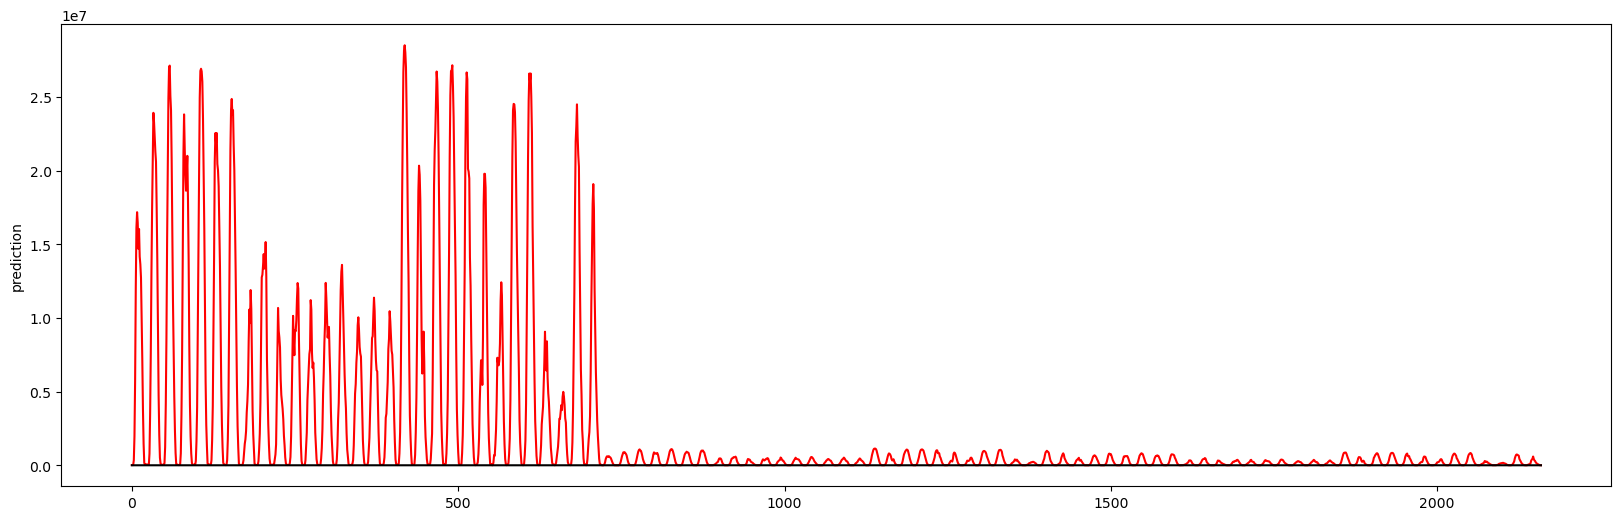

KeyError: 'hourDayMonthYear'

In [ ]:
m_wrap.plot_yPredSub_vs_submission(predictions_mean, X_sub_agg)
m_wrap.y_pred_to_csv(predictions_mean,X_train_agg,True,'building_bagging.csv',1)

In [ ]:
predictions_mean

0    274.467289
dtype: float64